# Advancing Heart Disease Detection With KNN Machine Learning Classifier

Cardiovascular disease accounted for  19.91 million global deaths in 2021, approximately **27%** of the world’s total death count, according to the [American Heart Association](https://www.ahajournals.org/doi/10.1161/CIR.0000000000001209?utm_campaign=sciencenews23-24&utm_source=science-news&utm_medium=phd-link&utm_content=phd-01-24-24#).

In this project, we will use the K-nearest neighbors (KNN) algorithm, a supervised learning classifier from scikit-learn, to enhance the detection of potential heart disease cases.

The dataset was compiled using five other small datasets, making it one of the largest publicly available heart disease datasets. You can find more information on the dataset [here](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data).

In [1]:
!pip install scikit-learn

# import libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving heart.csv to heart (1).csv


In [3]:
df = pd.read_csv('heart.csv')
print(df.shape)
df.head()

(918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


The dataset contains no missing values, so we're ready to move on.

## EDA: Descriptive Statistics
Let's take a closer look at our data.

In [5]:
df.dtypes.value_counts()

,count
int64,6
object,5
float64,1


Two numerical features, `FastingBS` and `HeartDisease`, are categorical, so let's convert them to avoid confusion later.


In [6]:
df['FastingBS'] = df['FastingBS'].astype('object')
df['HeartDisease'] = df['HeartDisease'].astype('object')
df.dtypes.value_counts()

,count
object,7
int64,4
float64,1


In [7]:
df.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


`RestingBP` and `Cholesterol` have minimum values at zero, so let's take a quick look.

In [8]:
print(df[df['Cholesterol'] == 0].shape[0])
print(df[df['RestingBP'] == 0].shape[0])

172
1


Nearly 20% of the values for `Cholesterol` are zero, greatly skewing our results.

The `Cholesterol` measure is calculated by adding HDL and LDL cholesterol levels, plus 20% of triglyceride levels, as detailed by the American Heart Association [here](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean).


 `RestingBP` is simply resting blood pressure, which cannot be zero.

 We will handle the errors when cleaning.

## EDA: Visualizations
Let's take a look at our categorical columns.

In [9]:
df.describe(include='object')

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
count,918,918,918,918,918,918,918
unique,2,4,2,3,2,3,2
top,M,ASY,0,Normal,N,Flat,1
freq,725,496,704,552,547,460,508


Let's first see how the values are distributed.

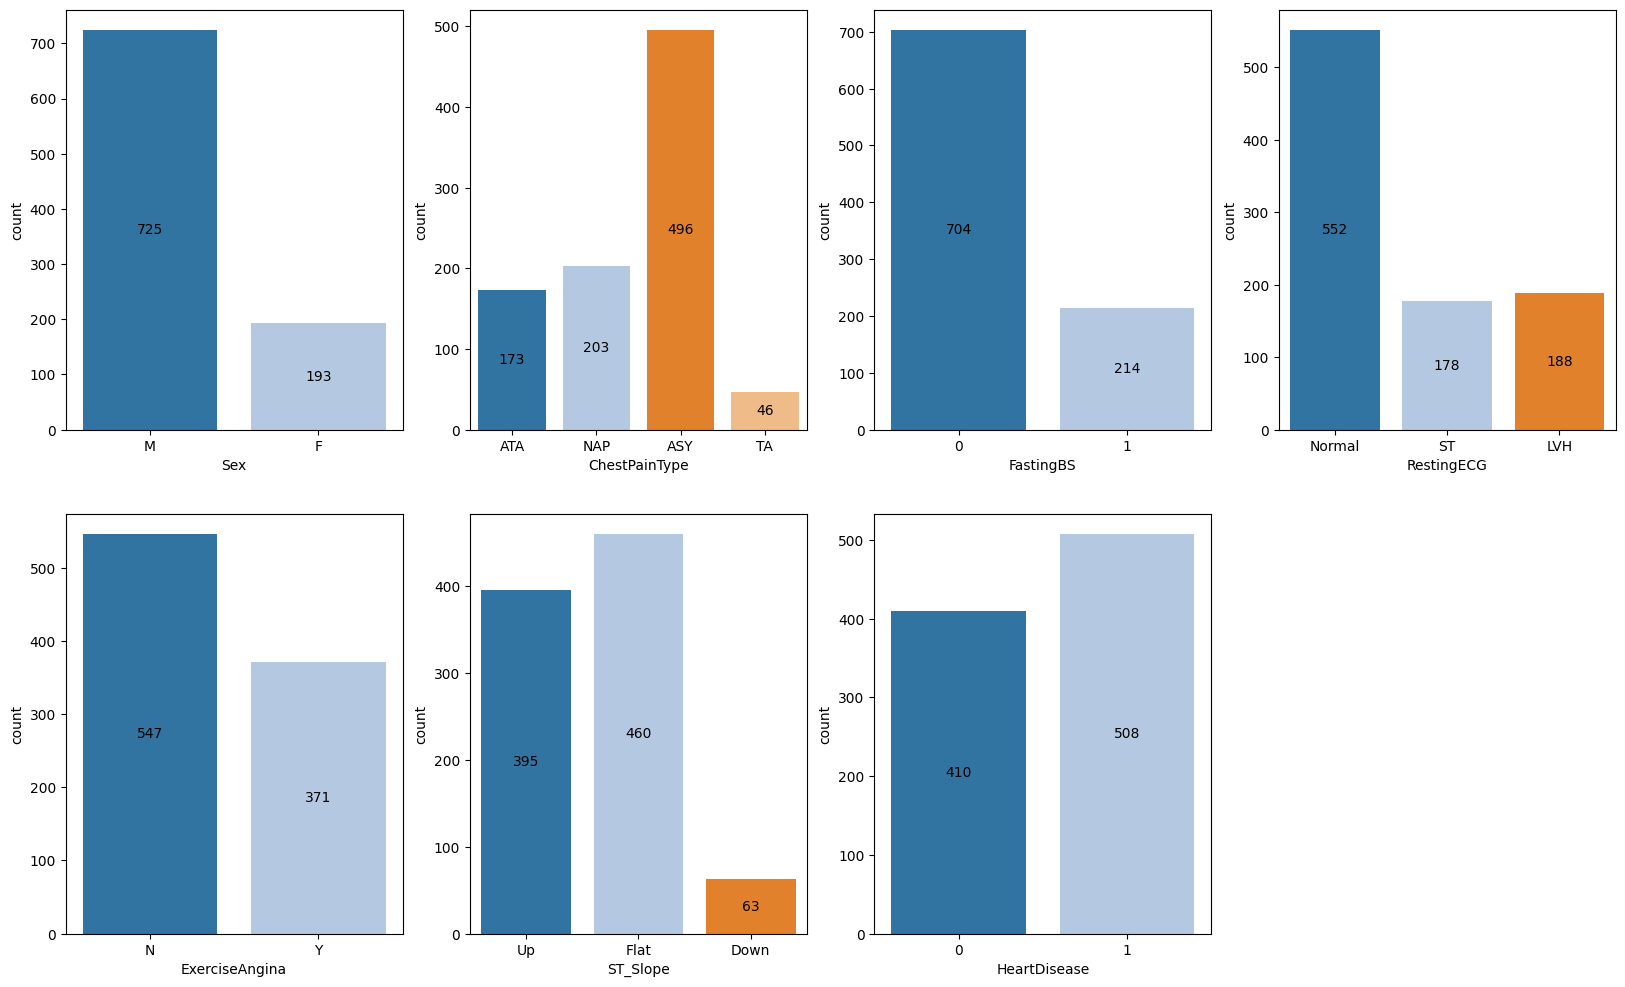

In [10]:
fig = plt.figure(figsize=(20,12))

for index, col in enumerate(df.select_dtypes(include = 'object')):
    ax = plt.subplot(2, 4, index+1,)
    sns.countplot(x=df[col], ax=ax, palette='tab20',hue=df[col],legend=False)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

Now let's see each variable grouped by the `HeartDisease` column.

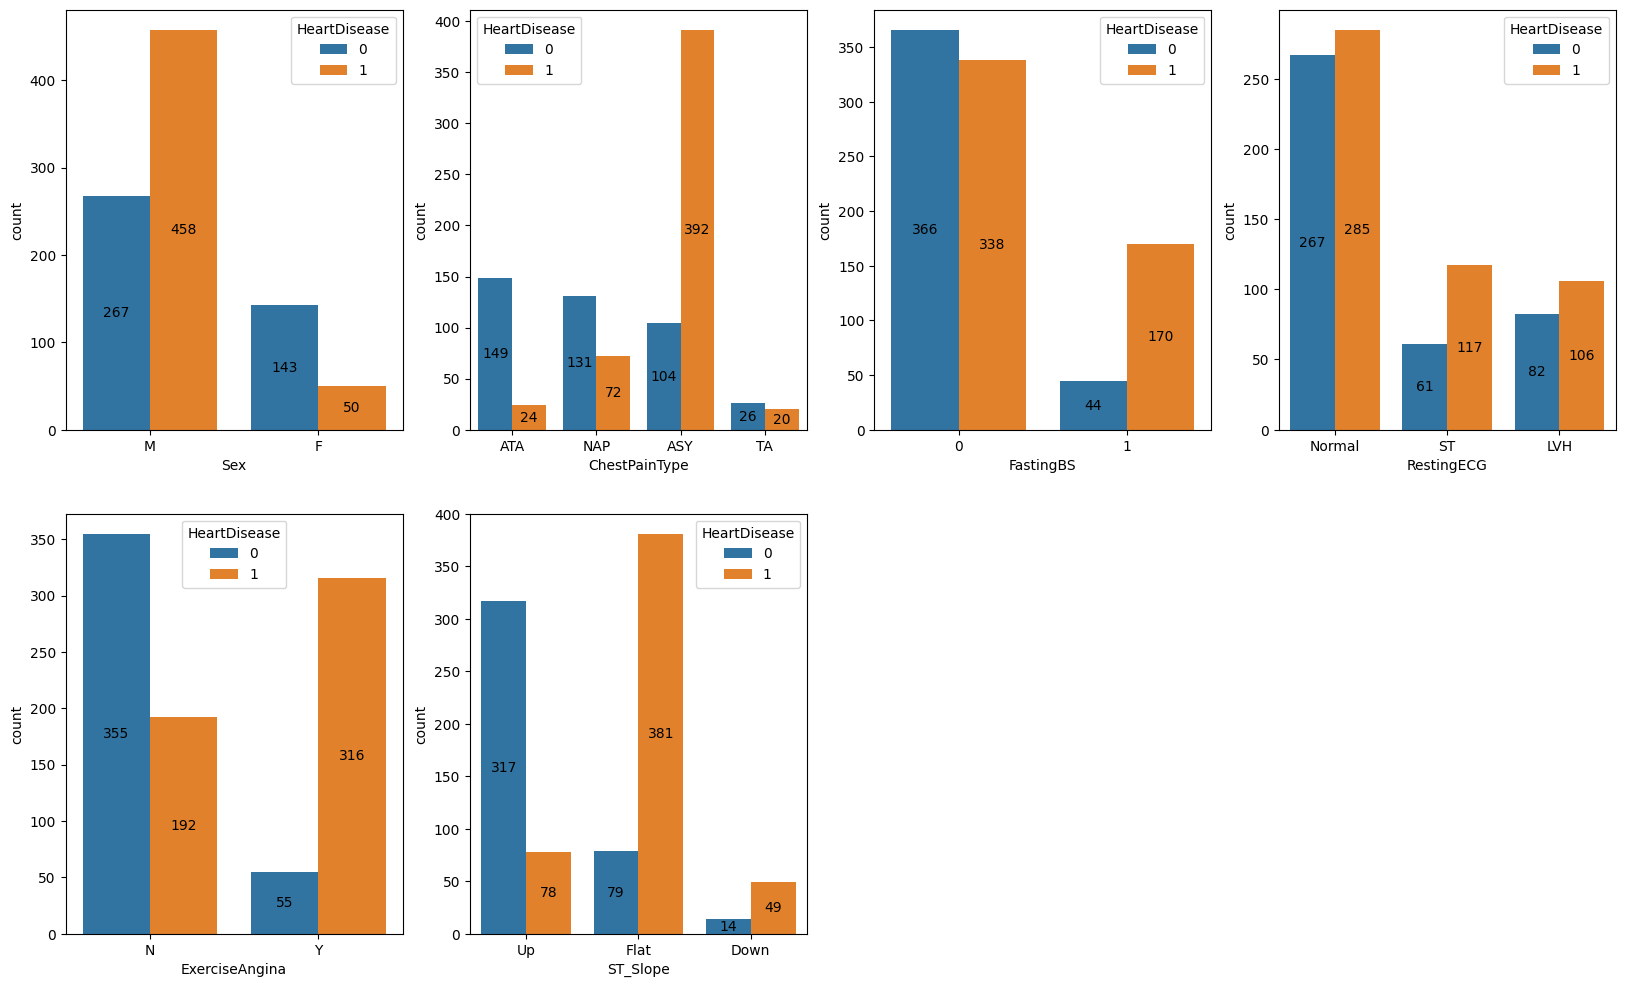

In [11]:
fig = plt.figure(figsize=(20,12))

for index, col in enumerate(df.select_dtypes(include = 'object').drop('HeartDisease',axis=1)): #exclude HeartDisease col
    ax = plt.subplot(2, 4, index+1)
    sns.countplot(x=df[col], ax=ax,palette='tab10',hue=df['HeartDisease'])
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

A few things stand out to me:
   - When looking at `ChestPainType`, it appears that being asymptomatic is a strong indicator of ***having*** heart disease, which seems counterintuitive.
   - The men in the dataset are far more likely to have heart disease than
  the women. While also true at the societal level, this has led to underrecognition and undertreatment of female sufferers, an issue outlined by [Harvard Health Publishing](https://www.health.harvard.edu/heart-health/the-heart-disease-gender-gap).
   - `ST_Slope`, `FastingBS`, and `ExerciseAngina`, all appear, at least visually, to have some correlation with heart disease diagnosis.

## Data Cleaning
Let's address the missing data identified earlier:

1. `RestingBP`

    There is only one row with a `RestingBP` of zero. We can safely remove this row without significantly impacting the dataset.

2. `Cholesterol`

    We have 172 entries with a `Cholesterol` level of zero. Removing these rows would lead to a substantial reduction in the dataset size.

    To determine the best approach, let's first investigate how `Cholesterol` levels are impacted by our target variable, `HeartDisease`. This analysis will help us decide whether to impute missing values or handle them differently.

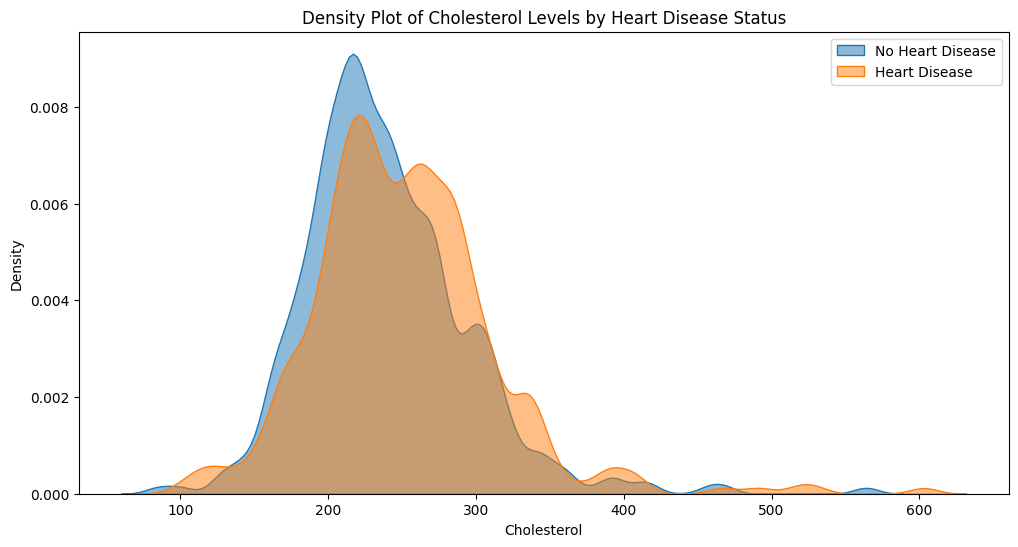

,HeartDisease,Median_Cholesterol,Mean_Cholesterol,STD_Cholesterol
0,0,231.5,238.77,55.39
1,1,246.0,251.06,62.46


In [12]:
# Only looking at complete data
df_non_zeros = df[df['Cholesterol'] != 0]

# Plotting density plots for each group
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_non_zeros[df_non_zeros['HeartDisease'] == 0],
            x='Cholesterol', label='No Heart Disease', fill=True, alpha=0.5, bw_adjust=.5)
sns.kdeplot(data=df_non_zeros[df_non_zeros['HeartDisease'] == 1],
            x='Cholesterol', label='Heart Disease', fill=True, alpha=0.5,bw_adjust=.5)
plt.title('Density Plot of Cholesterol Levels by Heart Disease Status')
plt.xlabel('Cholesterol')
plt.ylabel('Density')
plt.legend()
plt.show()

#Calculate summary statistics for both groups
median_0 = df_non_zeros[df_non_zeros['HeartDisease'] == 0]['Cholesterol'].median()
mean_0 = round(df_non_zeros[df_non_zeros['HeartDisease'] == 0]['Cholesterol'].mean(),2)

median_1= df_non_zeros[df_non_zeros['HeartDisease'] == 1]['Cholesterol'].median()
mean_1 = round(df_non_zeros[df_non_zeros['HeartDisease'] == 1]['Cholesterol'].mean(),2)

std_0 = round(df_non_zeros[df_non_zeros['HeartDisease'] == 0]['Cholesterol'].std(),2)
std_1 = round(df_non_zeros[df_non_zeros['HeartDisease'] == 1]['Cholesterol'].std(),2)

stats = pd.DataFrame(data = {
            'HeartDisease': [0, 1],
            'Median_Cholesterol': [median_0, median_1],
            'Mean_Cholesterol': [mean_0, mean_1],
            'STD_Cholesterol': [std_0, std_1]
            })
stats

We learn two things from this plot:

- The outliers do not appear to cause a significant change in our data, so we can choose  **mean** or **median** imputation without a problem.
- It appears cholesterol levels may correlated with heart disease, so we should strongly consider grouping by heart disease diagnosis.

Let's be more precise and determine which variables are most strongly correlated with `Cholesterol`.

In [13]:
# Transform categorical variables to dummy 'numerical' variables
df_dummies = pd.get_dummies(df_non_zeros, drop_first=True)
corr_matrix = abs(df_dummies.corr())

# Just look at correlations with Cholesterol column
corr_with_cholesterol = corr_matrix['Cholesterol'].drop('Cholesterol').sort_values(ascending=False)

print("Correlation with Cholesterol by Variable:")
print(corr_with_cholesterol)

Correlation with Cholesterol by Variable:
Sex_M                0.107045
ST_Slope_Flat        0.103996
HeartDisease_1       0.103866
ST_Slope_Up          0.099063
RestingBP            0.095939
ExerciseAngina_Y     0.086768
ChestPainType_NAP    0.068441
Age                  0.058758
Oldpeak              0.058488
FastingBS_1          0.054012
ChestPainType_TA     0.050253
RestingECG_Normal    0.046950
RestingECG_ST        0.028806
MaxHR                0.019856
ChestPainType_ATA    0.015945
Name: Cholesterol, dtype: float64


No single variable in our dataset is strongly correlated with `Cholesterol` when removing the **0** values, but `Sex`, `ST_Slope`, and `HeartDisease` have a slight correlation, so we'll group by those columns and then impute the mean values for each group.

Note: Median imputation would work here as well.

In [14]:
# Group by the specified columns and calculate the mean of 'Cholesterol'
grouped_df = df_non_zeros.groupby(['Sex', 'ST_Slope', 'HeartDisease'])['Cholesterol'].mean().reset_index()

# Rename the 'Cholesterol' column to indicate it is a mean value
grouped_df.rename(columns={'Cholesterol': 'MeanCholesterol'}, inplace=True)

grouped_df

,Sex,ST_Slope,HeartDisease,MeanCholesterol
0,F,Down,0,201.500000
1,F,Down,1,240.000000
2,F,Flat,0,250.222222
3,F,Flat,1,279.205882
4,F,Up,0,249.740385
5,F,Up,1,318.000000
6,M,Down,0,274.555556
7,M,Down,1,235.000000
8,M,Flat,0,236.384615
9,M,Flat,1,249.677551


Finally, we'll drop the missing `RestingBP` row and impute our grouped means into our data frame.

In [15]:
# Copy the DataFrame to avoid modifying the original data
df_clean = df.copy()

# Remove row missing RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

# Merge data frames
df_final = pd.merge(df_clean, grouped_df, on=['Sex', 'ST_Slope', 'HeartDisease'], how='left')

# For columns missing cholesterol, we will impute our means
df_final['Cholesterol'] = df_final.apply(
    lambda row: row['MeanCholesterol'] if row['Cholesterol'] == 0 else row['Cholesterol'], axis=1
)
# Drop the 'MeanCholesterol' column as it's no longer needed
df_final.drop(columns=['MeanCholesterol'], inplace=True)

df_final

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195.0,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
912,45,M,TA,110,264.0,0,Normal,132,N,1.2,Flat,1
913,68,M,ASY,144,193.0,1,Normal,141,N,3.4,Flat,1
914,57,M,ASY,130,131.0,0,Normal,115,Y,1.2,Flat,1
915,57,F,ATA,130,236.0,0,LVH,174,N,0.0,Flat,1


In [16]:
print(f"Missing Cholesterol values = {df_final[df_final['Cholesterol'] == 0].shape[0]}")

Missing Cholesterol values = 0


Excellent! We can now continue.

## Feature Selection

We now have to select the features for our modeling process.

There are several "acceptable" ways to go about this process when considering the size, nature, and specific goals of our dataset and analysis. In this case, I've decided to keep all feature columns, at least to begin.

The rationale behind this decision is twofold.

Firstly, in smaller datasets, each feature represents a valuable piece of information that can potentially contribute to the predictive accuracy of the model. The loss of any data might lead to the model missing out on key insights that could improve its performance.

Secondly, smaller datasets are less likely to suffer from the curse of dimensionality than larger datasets. This phenomenon occurs when the feature space becomes so large that the data points become sparse and scattered, making it challenging for the model to find meaningful patterns.

By using all available features, we aim to capture as much information as possible, enhancing the model's capacity to make accurate predictions without the immediate need for dimensionality reduction techniques. However, if we find that our model is not performing as well as we hoped, we will retrospectively remove features using PCA (principal component analysis).

With that said, we must still convert the categorical variables in the dataset into dummy variables.

In [17]:
df_final = pd.get_dummies(df_final,drop_first=True)
df_final.rename(columns= lambda x: x.replace('_1',''),inplace=True) #Fix renaming issue in FastingBS and HeartDisease
df_final.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289.0,172,0.0,True,True,False,False,False,True,False,False,False,True,False
1,49,160,180.0,156,1.0,False,False,True,False,False,True,False,False,True,False,True
2,37,130,283.0,98,0.0,True,True,False,False,False,False,True,False,False,True,False
3,48,138,214.0,108,1.5,False,False,False,False,False,True,False,True,True,False,True
4,54,150,195.0,122,0.0,True,False,True,False,False,True,False,False,False,True,False


## Building a Classifier
We will start by splitting our data into training and test sets.

Instead of using a separate validation set, we’ll use `GridSearchCV` for hyperparameter tuning. This tool performs cross-validation, which divides the training data into multiple subsets to evaluate model performance. This approach negates the need for a separate validation set by ensuring that each hyperparameter combination is tested across different data folds.

In [18]:
X = df_final.drop(['HeartDisease'],axis=1)
y = df_final['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 222)

Normalizing data is crucial for KNN because the algorithm relies on calculating distances between data points. If features are on different scales, those with larger ranges can disproportionately influence the distance calculation, leading to biased results.

To address this, we chose to use `MinMaxScaler` to scale our numeric features, which does so to the range (0, 1).


`MinMaxScaler` is the best choice for our data because it keeps the original distribution and relationships between features like age, resting heart rate, cholesterol, and others, which all have specific natural ranges, as opposed to the popular `StandardScaler`, which might not maintain these original relationships.

In [19]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now we have to use `GridSearchCV` to find the optimal hyperparameters for our model.


In [20]:
params = {
    'n_neighbors': range(1, 11),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'metric': ['minkowski', 'manhattan', 'euclidean'],
    }

knn = KNeighborsClassifier()
model = GridSearchCV(knn, params)
model.fit(X_train_scaled, y_train)
best_score = model.best_score_
best_params = model.best_params_
print("Best score: ", best_score)
print("Best parameters: ", best_params)

Best score:  0.8404062995061038
Best parameters:  {'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}


We were able to reach a training accuracy of 84%, which in this context is a good number. Let's see how well our model performs on the test set.

In [21]:
accuracy = model.best_estimator_.score(X_test_scaled, y_test)
print(accuracy)

0.8967391304347826


Let's see if we can improve that near 90% figure even further with PCA.

## Feature Selection with PCA
I chose to retroactively reduce features with PCA instead of proactively using Pearson correlation for two main reasons:

1. **Capturing Relationships**: Pearson correlation only measures linear relationships between individual features and the target, potentially missing important non-linear interactions. In contrast, PCA aims to capture the overall variance in the data, including complex, multi-dimensional relationships among features.

2. **Addressing Multicollinearity**: PCA reduces issues with multicollinearity by transforming the original features into new components that capture the most variance in the data. This helps mitigate redundancy among features, which Pearson correlation cannot directly address.

In [22]:
# Splitting and scaling data again
X = df_final.drop(['HeartDisease'],axis=1)
y = df_final['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 222)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
print(f'Number of features before PCA: {len(list(X))}')

Number of features before PCA: 15


To determine the optimal number of principal components for our PCA, we need to evaluate how much of the total variance in the data is captured by the components. The explained variance ratio indicates the proportion of variance each principal component accounts for individually.

We will then calculate the cumulative explained variance in an effort to determine how many features are needed to capture a specified percentage of the total variance. In this case, 90% will be our aim.

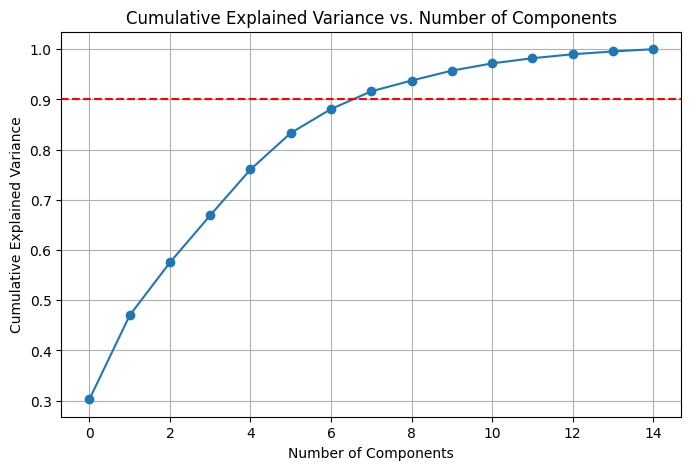

In [24]:
# Fit PCA to the training data
pca = PCA()
pca.fit(X_train_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


We can explain 90% of the variance at 7 features, so we'll go with that.

In [25]:
pca = PCA(n_components = 7, svd_solver = 'full')
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'Number of features after PCA: {len(list(X_train_pca[0]))}')

Number of features after PCA: 7


We can now repeat our grid search.

In [26]:
knn = KNeighborsClassifier()
model = GridSearchCV(knn, params)
model.fit(X_train_pca, y_train)
best_score = model.best_score_
best_params = model.best_params_
print("Best score: ", best_score)
print("Best parameters: ", best_params)

Best score:  0.8431180691454664
Best parameters:  {'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}


Our grid search resulted in the same parameters and a similar accuracy on our training data as before PCA.

Let's see if it improves our results on the test set.

In [27]:
accuracy = model.best_estimator_.score(X_test_pca, y_test)
print(accuracy)

0.907608695652174


We achieved a test set accuracy of 91% after applying PCA, compared to about 90% before PCA. The training set accuracy stayed around 84% for pre and post-PCA. This discrepancy suggests a few considerations:

1. **Test Set Variability**: The higher test set accuracy could be due to variability or characteristics in the test data that are more favorable for the model.

2. **Impact of Random State**: The `random_state` parameter affects how data is split into training and test sets. It’s possible that we experienced a fortunate split with particularly favorable test data. To ensure the robustness of our model’s performance, we should run the algorithm multiple times with different data splits to verify if the high test accuracy is consistent.

Overall, I am very pleased at the accuracy of the model, and hope that figure can be pushed even higher over time with a larger collection of data entries.